In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv("conversion_data.csv")

In [9]:
data.sample(n=5)

,country,age,new_user,source,total_pages_visited,converted
109646,US,20,1,Seo,3,0
15206,US,24,1,Ads,4,0
170963,US,34,1,Ads,4,0
119803,US,20,1,Direct,2,0
129351,US,50,1,Ads,2,0


Above is some sample data showing the available fields. Two of these are purely categorical, the user's country, and the marketing channel source. We will start by considering the non-categorical fields.

In [18]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


An important thing to note here is that very few sessions (about 3%) result in a purchase. The site recieves customers with an average age around 30. Overall, this seems to be a young crowd, with 75% below age 36. A modest majority of those customers are visiting for the first time. Customers tend to browse a few pages before they leave.

In [5]:
data.corr()["converted"]

age                   -0.088797
new_user              -0.152374
total_pages_visited    0.528994
converted              1.000000
Name: converted, dtype: float64

Looking at correlations for the numeric data, it seems that older customers and new customers less likely to make a purchase. Customers who stay on the website longer, however, are much more likely to buy something. These trends sound reasonable.

Text(0,0.5,'conversion rate')

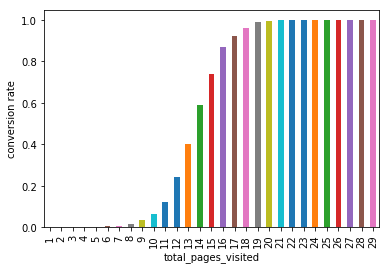

In [179]:
ax = data.groupby("total_pages_visited")["converted"].mean().plot(kind="bar")
ax.set_ylabel("conversion rate")

The above plot shows the importance of page visits. Customers that visit fewer than 10 pages are unlikely to make a purchase. Customers that visit more than 17 or more pages are virtually guaranteed to.

Text(0,0.5,'conversion rate')

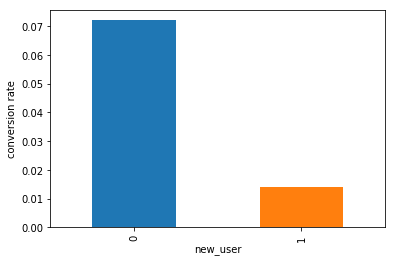

In [180]:
ax = data.groupby("new_user")["converted"].mean().plot(kind="bar")
ax.set_ylabel("conversion rate")

The above plot shows that returning users are much more likely to make a purchase.

# Categorical Fields

In [17]:
print(data['country'].value_counts())
print()
print(data['source'].value_counts())

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64


In this dataset, only four countries are represented.

In [44]:
print(f'Conversion rate by country:\n{data.groupby("country")["converted"].mean()}')
print()
print(f'Conversion rate by source:\n{data.groupby("source")["converted"].mean()}')

Conversion rate by country:
country
China      0.001332
Germany    0.062500
UK         0.052632
US         0.037801
Name: converted, dtype: float64

Conversion rate by source:
source
Ads       0.034483
Direct    0.028169
Seo       0.032895
Name: converted, dtype: float64


A quick look at conversion rates for each category shows an important feature. Customers from China very rarely make purchases. Marketing channel source.

Text(0,0.5,'conversion rate')

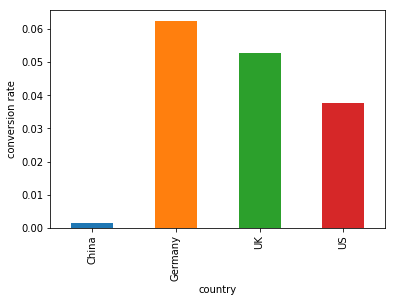

In [46]:
ax = data.groupby("country")["converted"].mean().plot(kind="bar")
ax.set_ylabel("conversion rate")

The above plot makes the conversion rate's dependence on country clear.

In [173]:
data_dummies = pd.get_dummies(data, prefix=["country", "source"]).drop(["country_US", "source_Direct"],1)
data_dummies.columns = map(str.lower, data_dummies.columns)


For each categorical field, I created an extra dummy field per category. One category from each field is omitted, as it is redundant. I chose to omit country_US and source_Direct. These will become baselines for these fields.

In [174]:
data_dummies.sample(n=5)

,age,new_user,total_pages_visited,converted,country_china,country_germany,country_uk,source_ads,source_seo
304968,36,1,1,0,0,0,0,0,1
259559,35,1,4,0,1,0,0,0,0
73646,22,1,6,0,0,0,0,0,1
214404,25,0,3,0,0,0,0,1,0
225953,34,1,10,0,0,0,0,1,0


# Logistic Model

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_dummies.drop(["converted"], 1), data_dummies['converted'], random_state=0)
lr = LogisticRegression().fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

I used a logistic model to predict conversion probabilities. It's a simple and natural choice for this binary classification task. The coefficients it finds can be interpreted to find the relative importance of the input fields, which can be used to provide recommendations for the marketing team.

I split up the data into training and test sets. I also trained two dumb classifiers for comparison. One classifies randomly with a convertion probability that respects that of the data set. The other classifies every point with the most common answer in the original data set. In this case, that's converted=0.

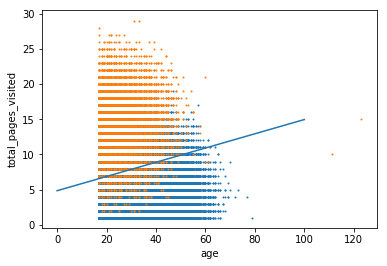

In [154]:
weights = {name: w for (name, w) in zip(X_train.columns, lr.coef_[0])}
intercept = lr.intercept_[0]

plt.figure()
plt.scatter(data_dummies[data_dummies["converted"]==0.]["age"],data_dummies[data_dummies["converted"]==0.]["total_pages_visited"], s=1)
plt.scatter(data_dummies[data_dummies["converted"]==1.]["age"],data_dummies[data_dummies["converted"]==1.]["total_pages_visited"], s=1)
x = np.linspace(0, 100, 1000)
plt.plot(x, -intercept - (weights["age"]/weights["total_pages_visited"] * x));
plt.xlabel("age")
plt.ylabel("total_pages_visited")

plt.show()

The above plot shows a slice of the data with the logistic regression result. Orange dots indicate sessions that resulted in purchase. Blue dots indicate sessions that didn't. The blue line shows a projection of the decision boundary. 

In [181]:
for (name, b) in zip(X_train.columns,lr.coef_[0]):
    print(f'{b:.3f} ← {name}')

print()
print(f'{np.exp(lr.intercept_[0]):.5f} ← intercept')

-0.077 ← age
-1.678 ← new_user
0.756 ← total_pages_visited
-3.292 ← country_china
0.603 ← country_germany
0.347 ← country_uk
0.213 ← source_ads
0.158 ← source_seo

0.00073 ← intercept


The coefficients from the logistic regression show the effect of each field. 

Older customers are less likely to make purchases. Each year of age corresponds to a small decrease in purchase probabiliy.

New customers are less likely to make purchases. This agrees with our earlier analysis. Being a new customer is equivalent to being twenty years older.

Customers that visit more pages are much more likely to make purchases. This agrees with our earlier analysis. Each page visited is equivalent to being ten years younger.

As we saw earlier, country is an important field. Because customers from China make purchases much less frequently, the country_china coefficient is large and negative. Sessions from Germany and the UK are somewhat more effective than those from the US, and correspondingly have small positive coefficients. In terms of conversion probability, a customer from China is equivalent to one from the US who is 40 years older.

Source doesn't seem to have a strong effect, but customers that arrive via search engines or ad clicks are more likely to make a purchase. Arriving via an ad is equivalent to being about three years younger.

In [194]:
print(f'Training score {lr.score(X_train, y_train)}')
print()
print(f'Test score {lr.score(X_test, y_test)}')
print(f'Dummy score {dummy.score(X_test, y_test)}')
print(f'Most Frequent score {dummy_majority.score(X_test, y_test)}')

Training score 0.9862745098039216

Test score 0.9857938013915244
Dummy score 0.9367994939911448
Most Frequent score 0.9671473750790639


Above are the results of the models on the test data set. The logistic model correctly predicted whether a session would result in a purchase 99% of the time. This isn't as impressive as it sounds. Random guessing and always guessing 'no purchase' also agree with the data 94% and 97% of the time. This is a bad test, because the answers are so lopsided, with almost all sessions resulting in no purchase.

In [192]:
from sklearn.metrics import f1_score

print(f'Logistic Regression f1 score {f1_score(y_test, lr.predict(X_test))}')
print(f'Dummy f1 score {f1_score(y_test, dummy.predict(X_test))}')

Logistic Regression f1 score 0.7584426758442676
Dummy f1 score 0.03136787770498312


The $F_1$ score accounts for this lopsided data. This metric shows the logistic regression to be meaningfully more predictive than random guessing.

## Conclusion

Overall, there are useful conclusions to be drawn here. The advertising team could target younger customers and customers who have already visited once. They could also advertise more in Europe and less in China.

Because customers that spend more time on the site are more likely to buy something, the website could be tweaked with this in mind.

Perhaps the product team could offer items that appeal more to older customers and to customers in China.

It may be that the correlation between page visits and purchase probability does not imply causation in the way we have suggested. Customers that buy a product probably need to access several extra pages to complete the purchase. The extra page views could result from the purchase itself, and not the other way around. Maybe cart and checkout pages could be excluded from the page view count in future data sets.

The age data seems a little fishy. Someone who was 126 used this website? No one below 17? These self-reported ages could be flawed. Age histograms don't show any pattern that is obvious to me, though.